<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/NewNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
!unzip -qq train.zip

In [ ]:
!unzip -qq blur.zip

In [ ]:
from PIL import Image
from numpy import *
train = []
files = glob.glob ("blur/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    train.append (image)
train = np.array(train) 
train= np.reshape(train,[train.shape[0],train.shape[1],train.shape[2],train.shape[3]])
np.save('train-blur-images',train)

In [ ]:
label = []
files = glob.glob ("label/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    label.append (image)
label = np.array(label) 
label= np.reshape(label,[train.shape[0],label.shape[1],label.shape[2],label.shape[3]])
np.save('label-images',label)

In [5]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [6]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [33]:
dX=[]
def ResNet50():
    #X_input = keras.Input(shape=input_shape)
    X_input = layers.Input(shape=(224, 224, 3))
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    #4*4*2048
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(147, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    output = Dense( 1,activation='sigmoid', name='fc4',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=output , name='ResNet50')
    return model

In [35]:
baseModel=ResNet50()
#baseModel.summary()

In [28]:
def decoder_network():
    x_input = layers.Input(shape=(147))
    x = keras.layers.Reshape([7,7,3])(x_input)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    output = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    model = Model(inputs=x_input, outputs=output, name='decoder_network')
    return model


In [29]:
headModel=decoder_network()
headModel.summary()

Model: "decoder_network"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 147)]             0         
                                                                 
 reshape_6 (Reshape)         (None, 7, 7, 3)           0         
                                                                 
 conv2d_transpose_48 (Conv2D  (None, 14, 14, 3)        84        
 Transpose)                                                      
                                                                 
 conv2d_transpose_49 (Conv2D  (None, 28, 28, 3)        84        
 Transpose)                                                      
                                                                 
 conv2d_transpose_50 (Conv2D  (None, 56, 56, 3)        84        
 Transpose)                                                      
                                                   

In [37]:
#model = Model(inputs=base_model.input, outputs=headModel)
#keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(keras.optimizers.Adam(learning_rate=1e-3),
                        loss=tf.keras.losses.MeanSquaredError(),)


In [ ]:
x_train = np.load('train.npy')
y_train = np.load('label.npy')
x_train = x_train.astype(np.float32)/ 255.0
y_train = y_train.astype(np.float32)/ 255.0

In [ ]:
#model.summary()

In [ ]:
## Optimize
history = model.fit(x_train,y_train, epochs=30,batch_size=20, validation_split=0.2, shuffle=True)
model.save('new_model.h5')

Epoch 1/30
40/40 [==============================] - 10s 256ms/step - loss: 0.1335 - val_loss: 0.1513
Epoch 2/30
40/40 [==============================] - 10s 253ms/step - loss: 0.1329 - val_loss: 0.1820
Epoch 3/30
40/40 [==============================] - 11s 269ms/step - loss: 0.1305 - val_loss: 0.1379
Epoch 4/30
40/40 [==============================] - 10s 259ms/step - loss: 0.1279 - val_loss: 0.1603
Epoch 5/30
40/40 [==============================] - 10s 257ms/step - loss: 0.1265 - val_loss: 0.1703
Epoch 6/30
40/40 [==============================] - 10s 254ms/step - loss: 0.1250 - val_loss: 0.1356
Epoch 7/30
40/40 [==============================] - 11s 266ms/step - loss: 0.1248 - val_loss: 0.1421
Epoch 8/30
40/40 [==============================] - 10s 254ms/step - loss: 0.1218 - val_loss: 0.1295
Epoch 9/30
40/40 [==============================] - 10s 252ms/step - loss: 0.1223 - val_loss: 0.2611
Epoch 10/30
40/40 [==============================] - 10s 254ms/step - loss: 0.1211 - val_lo

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'val_loss'])


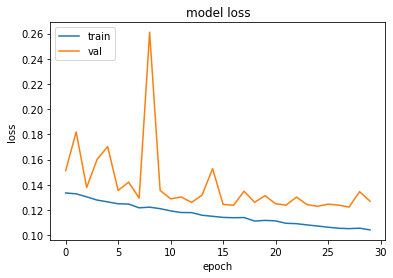

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
!unzip -qq test-blurry-images.zip

In [ ]:
from PIL import Image
from numpy import *
test = []
files = glob.glob ("test-blurry-images/*.jpg")
for myFile in files:
    image = array(Image.open(myFile))
    test.append (image)
test = np.array(test) 
test= np.reshape(test,[test.shape[0],test.shape[1],test.shape[2],test.shape[3]])
np.save('test-blurry-images',test)

In [ ]:
from keras.models import load_model
from PIL import Image
images = np.load('test-blurry-images.npy')
model = load_model("new_model.h5")
predictions=[]
batch_size=1
num_batches=len(images)//batch_size
for i in range(num_batches):
  img=images[i*batch_size : (i+1)*batch_size]
  img = img.astype(np.float32)/ 255.0
  pred = model.predict(img)
  predictions.append(pred)

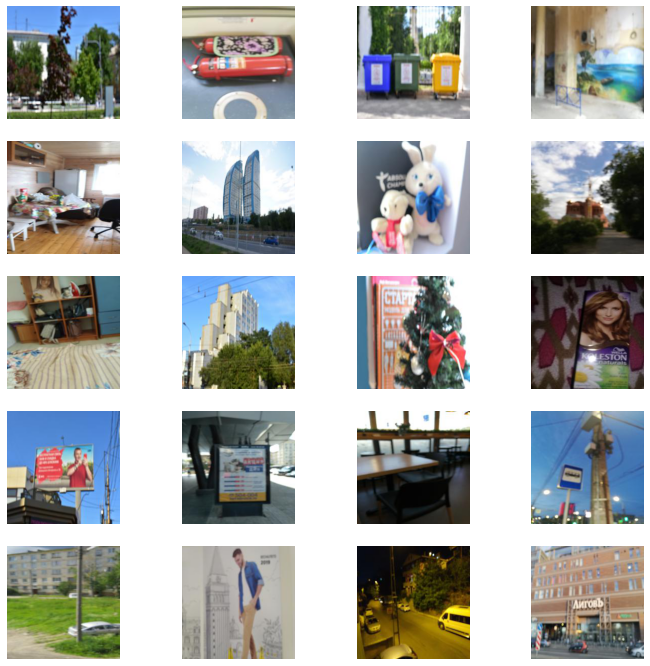

In [ ]:
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  plt.axis("off")
plt.show()

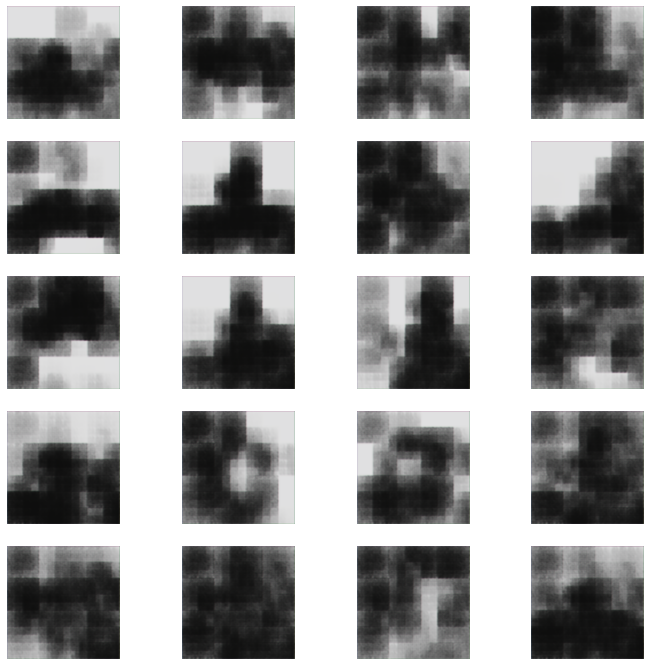

In [ ]:
predictions=np.reshape(predictions,(len(images),224,224,3))
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns,i+1)
    plt.imshow((predictions[i]*255.0).astype(np.uint8))
    plt.axis("off")
plt.show()

In [ ]:
def blurry_regions_with_red_color(image,pred):
  main_picture = Image.fromarray(image)
  final_image = main_picture.copy()
  label_picture = Image.fromarray((pred*255.0).astype(np.uint8))
  label_to_gray = label_picture.convert('L')
  rescale_label=label_to_gray.copy()
  rescale_label= np.array(rescale_label).astype(np.float32)/255.0
  width, height = label_to_gray.size
  for x in range(0, width - 1):
    for y in range(0, height - 1):
        current_color = final_image.getpixel((x,y))
        if (label_to_gray.getpixel((x,y)))>210:
            final_image.putpixel((x,y),(255,0,0) )
  return final_image

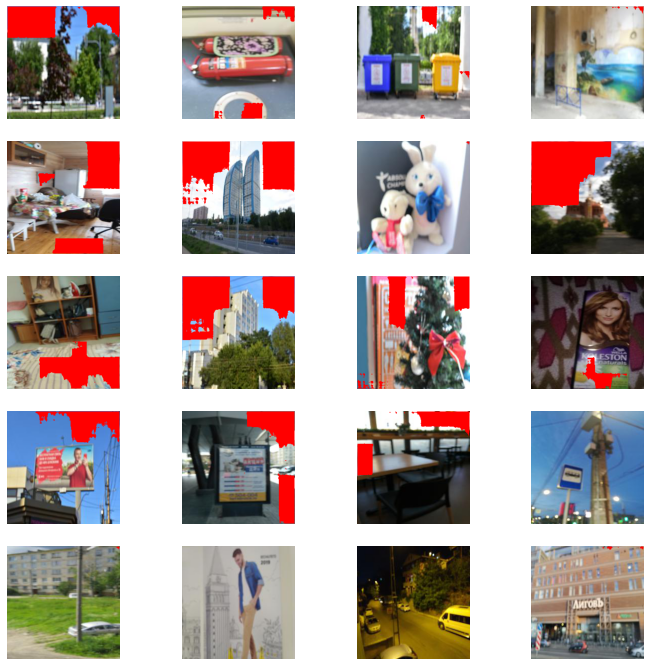

In [ ]:
h = 10
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(blurry_regions_with_red_color(images[i],predictions[i]),cmap='binary')
  plt.axis("off")
plt.show()